In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from keras.layers import Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import time

In [2]:
# 2. Load data
train_dir = r"../input/gender-classification-dataset/Training/"
test_dir = r"../input/gender-classification-dataset/Validation/"

CATEGORIES = {
    0: "FeMale",
    1: "Male"
}

img_width = 64
img_height = 64
img_channel = 3

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height),
                                                     subset='training', class_mode='binary')
val_generator = data_generator.flow_from_directory(train_dir, target_size=(img_width, img_height), 
                                                   subset='validation', class_mode='binary')
test_generator = data_generator.flow_from_directory(test_dir, target_size=(img_width, img_height), 
                                                    class_mode='binary')

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


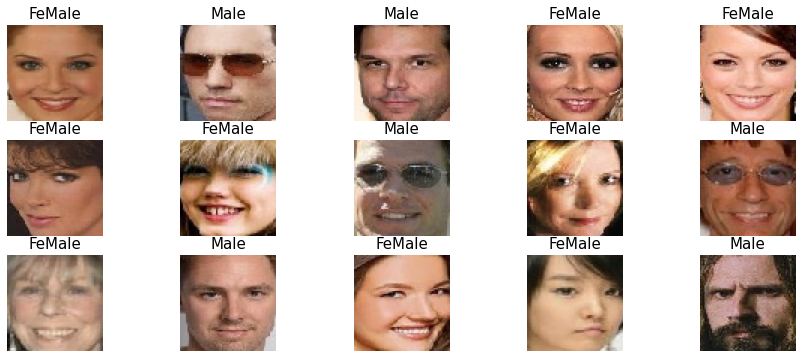

In [3]:
# 3. Show image
img, label = val_generator.next()
rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[label[i]], fontsize=15)

In [4]:
# 4. Build model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, img_channel)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

2022-07-14 09:03:34.735865: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# 5. Train model
start_time = time.time()

numOfEpoch = 10
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2,
                                            verbose = 1, factor = 0.5, min_lr = 0.00001)

H =  model.fit(train_generator, epochs = numOfEpoch, validation_data = val_generator, 
               verbose=1, callbacks=[earlystop,learning_rate_reduction])

end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

2022-07-14 09:03:35.193886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1176/1176 [==============================] - 307s 260ms/step - loss: 0.2341 - accuracy: 0.9038 - val_loss: 0.1485 - val_accuracy: 0.9452
Epoch 2/10
1176/1176 [==============================] - 107s 91ms/step - loss: 0.1514 - accuracy: 0.9450 - val_loss: 0.1296 - val_accuracy: 0.9532
Epoch 3/10
1176/1176 [==============================] - 106s 90ms/step - loss: 0.1313 - accuracy: 0.9524 - val_loss: 0.1245 - val_accuracy: 0.9535
Epoch 4/10
1176/1176 [==============================] - 108s 92ms/step - loss: 0.1227 - accuracy: 0.9556 - val_loss: 0.1255 - val_accuracy: 0.9546
Epoch 5/10
1176/1176 [==============================] - 111s 94ms/step - loss: 0.1121 - accuracy: 0.9593 - val_loss: 0.1688 - val_accuracy: 0.9349
Epoch 6/10
1176/1176 [==============================] - 109s 93ms/step - loss: 0.1057 - accuracy: 0.9637 - val_loss: 0.1353 - val_accuracy: 0.9521

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/10
1176/1176 [==============

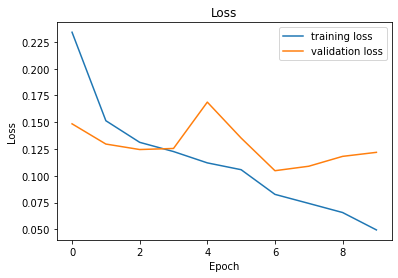

In [6]:
# 6. Vẽ đồ thị loss của traning set và validation set
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

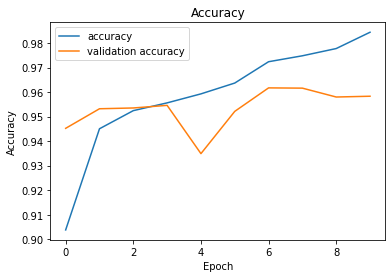

In [7]:
# 7. Vẽ đồ thị accuracy của traning set và validation set
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
# 8. Đánh giá model với testset
start_time = time.time()
print('[loss, accuracy]: ', model.evaluate(test_generator, verbose = 1))
end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

365/365 [==============================] - 69s 189ms/step - loss: 0.1106 - accuracy: 0.9621
[loss, accuracy]:  [0.11064041405916214, 0.9620568156242371]
Running time: 69.21 (s)


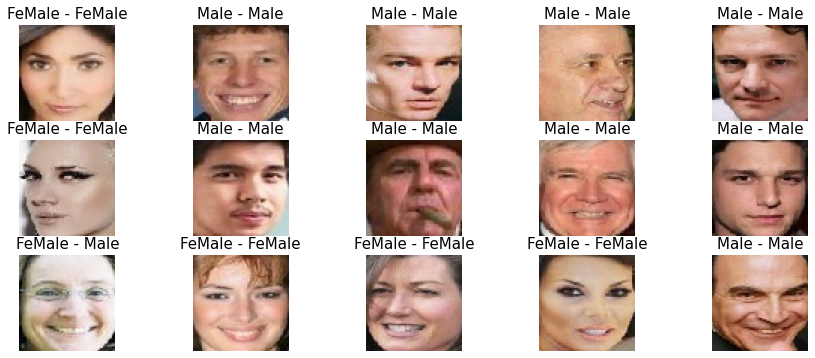

In [9]:
# 9. Show predict on tesetset
img, label = test_generator.next()
rows = 3
cols = 5

y_pred = model.predict(img[0: rows * cols])

fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    if y_pred[i] > 0.5 : y = 1
    else: y = 0
    axes[i].set_title(CATEGORIES[y] + ' - ' + CATEGORIES[label[i]], fontsize=15)

In [10]:
model.save("Gender_Classification_Model.h5")